# Diabetic Retinopathy Five Disease Level Classification using a Fully Trained CNN and Inception V3 Fine Tuning

## Input:
##### 1) Set up connection of Google Colab to Google Drive or comment out section for use on local computer
##### 2) Set up use of GPU for processing
##### 3) Set up directoy paths and excpected size of data
##### 4) Make sure the designated folder has data in the format of train/val/test with folders of resized_0, resized_1, resized_2, resized_3 and resized_4 for each 5 levels of Diabetic Retinopathy. Original data can be found at https://www.kaggle.com/c/diabetic-retinopathy-detection/data

## Output:
##### 1) Fine-tuned Inception V3 or fully trained Convolutional Neural Network is created
##### 2) JSON file with Accuracy and Cross Entrophy Loss based on Training and Validation Set for desired model

## Prints metrics for desired model
#### 1) Metrics of overall validation set accuracy, validation set confusion matrix, and accuracy for class 0 and class 1.
#### 2) Validation metrics are shared for test set
#### 3) Printed training loss and accuracy across epochs of training

# Setup

In [0]:
# Keras
import keras
from keras import metrics

# File and Folder Management
import os, shutil

# Store history
import json

Using TensorFlow backend.


2.2.5


In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_action = True

# Set directory
aaron_dir = "/content/drive/My Drive/Colab Notebooks/SML_Project"
#aaron_dir = '../SML_Project_Data'

directory = aaron_dir

In [0]:
!pwd
os.chdir(directory)
!ls

/content
best_model.hdf5
binary_data_4
binary_data_all
CNN_Diabetic_Retinopathy_Binary.ipynb
CNN_Diabetic_Retinopathy_Classification.ipynb
CNN_Diabetic_Retinopathy_Classification_old.ipynb
cross_entrophy_dim_500_class_566.h5
cross_entrophy_dim_500_class_count_566_new.h5
data_566
data_566_copy.zip
data_566.zip
data_zip
downsized_data.zip
history
inception_binary_dim_256_class_crop.h5
inception_binary_dim_500_class_4.h5
inception_binary_dim_500_class_566.h5
inception_binary_dim_500_class_all.h5
inception_binary_dim_500_class_all_rand.h5
inception_cross_entrophy_dim_500_class_566.h5
kNN_image_classification.ipynb
__MACOSX
train1.zip
trainLabels.csv


In [0]:
#!unzip -qq data_566_copy.zip

# Create Directories

In [0]:
# Directory of training data

original_base_dir = directory

data_folder_name = 'data_566'

base_dir = original_base_dir + "/" + data_folder_name

try:
    os.mkdir(base_dir)
except FileExistsError:
  print('Folder Already Exists \n')
else:
  print('Creating Folder \n')

Folder Already Exists 



In [0]:
history_dir = directory + '/history'

train_dir = os.path.join(directory, data_folder_name, 'train')
val_dir = os.path.join(directory, data_folder_name, 'val')

train_0_dir = os.path.join(train_dir, 'resized_0')
train_1_dir = os.path.join(train_dir, 'resized_1')
train_2_dir = os.path.join(train_dir, 'resized_2')
train_3_dir = os.path.join(train_dir, 'resized_3')
train_4_dir = os.path.join(train_dir, 'resized_4')

val_0_dir = os.path.join(val_dir, 'resized_0')
val_1_dir = os.path.join(val_dir, 'resized_1')
val_2_dir = os.path.join(val_dir, 'resized_2')
val_3_dir = os.path.join(val_dir, 'resized_3')
val_4_dir = os.path.join(val_dir, 'resized_4')

def create_folder(path):
  print('Looking to create folder of', path)
  try:
      os.mkdir(path)
  except FileExistsError:
    print('Folder Already Exists \n')
  else:
    print('Creating Folder \n')

In [0]:
# Store history files
history_dir = directory + '/history'
create_folder(history_dir)

Looking to create folder of /content/drive/My Drive/Colab Notebooks/SML_Project/history
Folder Already Exists 



In [0]:
# Create all Train and Validate Folders in Data with Folders for Each Class
for data_type in ('train', 'val'):
  for disease in (0, 1, 2, 3, 4):
    path = directory + '/' + data_folder_name + '/' + data_type + '/resized_' + str(disease)
    create_folder(path)

Looking to create folder of /content/drive/My Drive/Colab Notebooks/SML_Project/data_566/train/resized_0
Folder Already Exists 

Looking to create folder of /content/drive/My Drive/Colab Notebooks/SML_Project/data_566/train/resized_1
Folder Already Exists 

Looking to create folder of /content/drive/My Drive/Colab Notebooks/SML_Project/data_566/train/resized_2
Folder Already Exists 

Looking to create folder of /content/drive/My Drive/Colab Notebooks/SML_Project/data_566/train/resized_3
Folder Already Exists 

Looking to create folder of /content/drive/My Drive/Colab Notebooks/SML_Project/data_566/train/resized_4
Folder Already Exists 

Looking to create folder of /content/drive/My Drive/Colab Notebooks/SML_Project/data_566/val/resized_0
Folder Already Exists 

Looking to create folder of /content/drive/My Drive/Colab Notebooks/SML_Project/data_566/val/resized_1
Folder Already Exists 

Looking to create folder of /content/drive/My Drive/Colab Notebooks/SML_Project/data_566/val/resized_

In [0]:
from keras import layers
from keras import models

x = 500
y = 500

## Data preprocessing

In [0]:
from keras.preprocessing.image import ImageDataGenerator

data_generation = ImageDataGenerator(rescale=1./255)

batch_size = 20

train_generator = data_generation.flow_from_directory(
        # This is the target directory
        train_dir,
        target_size=(x, y),
        batch_size=batch_size,
        class_mode='categorical')
# 2830/5=566

validation_generator = data_generation.flow_from_directory(
        val_dir,
        target_size=(x, y),
        batch_size=batch_size,
        shuffle = False,
        class_mode='categorical')
# 355/5=71

# classes that will be used and dictionary for each name
print(train_generator.class_indices)

Found 2830 images belonging to 5 classes.
{'resized_0': 0, 'resized_1': 1, 'resized_2': 2, 'resized_3': 3, 'resized_4': 4}
Found 355 images belonging to 5 classes.


# CNN Training

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

saved_model_name = '/cross_entrophy_dim_500_class_566.h5'

if train_action == True:
  filepath = original_base_dir + saved_model_name
  checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  es = EarlyStopping(monitor='val_acc', mode='max', patience = 3)

  callbacks_list = [checkpoint, es]
    
  history = model.fit_generator(
        train_generator,
        steps_per_epoch=2830//20,
        epochs=15,
        validation_data=validation_generator,
        validation_steps=355//20,
        callbacks=callbacks_list,
        )

  # Save history object
  history_dict = history.history
  json.dump(history_dict, open(history_dir + '/history', 'w'))

# CNN Loss and Accuracy across Epochs

In [0]:
from keras.models import load_model
model1 = load_model(original_base_dir + saved_model_name)
model1

In [0]:
with open(original_base_dir + '/history/history') as json_file:
    history = json.load(json_file)
history.get('val_acc')

Let's plot the loss and accuracy of the model over the training and validation data during training:

In [0]:
import matplotlib.pyplot as plt

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Create Classification InceptionV3 Model

In [2]:
# InceptionV3
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras import layers, models
from keras.layers import Dropout

inception_saved_model_name = '/inception_cross_entrophy_dim_500_class_566.h5'

Using TensorFlow backend.


In [3]:
model = models.Sequential()

# Source of inspiration for code
# https://keras.io/applications/#inceptionv3

# create the base pre-trained model
model.add(InceptionV3(weights='imagenet', include_top=False))
for layer in model.layers:
    layer.trainable = False

# Add a Global Average Pooling Layer
model.add(GlobalAveragePooling2D())

# Add fully connected layer
model.add(Dense(1024, activation='relu'))

# Add dropout layer
model.add(Dropout(0.2))

# Add output layer
model.add(Dense(5, activation='softmax'))















87916544/87910968 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 23,906,085
Trainable params: 2,103,301
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['acc'])

from keras.callbacks import ModelCheckpoint, EarlyStopping
import math

In [0]:
inception_filepath = original_base_dir + inception_saved_model_name
inception_checkpoint = ModelCheckpoint(inception_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
inception_es = EarlyStopping(monitor='val_acc', mode='max', patience = 5)

inception_callbacks_list = [inception_checkpoint, inception_es]
inception_history = model.fit_generator(train_generator,
                                 steps_per_epoch=math.ceil(2830/batch_size),
        epochs=25,
        validation_data=validation_generator,
        validation_steps=math.ceil(355/batch_size),
        callbacks=inception_callbacks_list,
                                  verbose = 1
                                 )

# Get the dictionary containing each metric and the loss for each epoch and export to file
history_dict = inception_history.history
json.dump(history_dict, open(history_dir + '/inception_history', 'w'))

Epoch 1/25
142/142 [==============================] - 926s 7s/step - loss: 1.6154 - acc: 0.2183 - val_loss: 1.6117 - val_acc: 0.2254

Epoch 00001: val_acc improved from -inf to 0.22535, saving model to /content/drive/My Drive/Colab Notebooks/SML_Project/inception_cross_entrophy_dim_500_class_566.h5
Epoch 2/25
142/142 [==============================] - 32s 224ms/step - loss: 1.5405 - acc: 0.3190 - val_loss: 1.5828 - val_acc: 0.2676

Epoch 00002: val_acc improved from 0.22535 to 0.26761, saving model to /content/drive/My Drive/Colab Notebooks/SML_Project/inception_cross_entrophy_dim_500_class_566.h5
Epoch 3/25
142/142 [==============================] - 32s 229ms/step - loss: 1.4912 - acc: 0.3556 - val_loss: 1.5622 - val_acc: 0.2676

Epoch 00003: val_acc did not improve from 0.26761
Epoch 4/25
142/142 [==============================] - 33s 229ms/step - loss: 1.4351 - acc: 0.3852 - val_loss: 1.5473 - val_acc: 0.2592

Epoch 00004: val_acc did not improve from 0.26761
Epoch 5/25
142/142 [===

In [0]:
from keras.models import load_model
model_inception = load_model(original_base_dir + inception_saved_model_name)
model_inception.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['acc'])

model_inception














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
with open(original_base_dir + '/history/inception_history') as json_file:
    history = json.load(json_file)
history.get('val_acc')

[0.20294117993291685,
 0.23880597415255078,
 0.274626869763901,
 0.2895522442326617,
 0.34328358431360617,
 0.27761194109916687,
 0.32835821429295325,
 0.3820895530394654,
 0.30447761758939546,
 0.34925373054262415,
 0.3223880640606382,
 0.3134328367105171]

# Plot Training Loss and Accuracy across Epochs

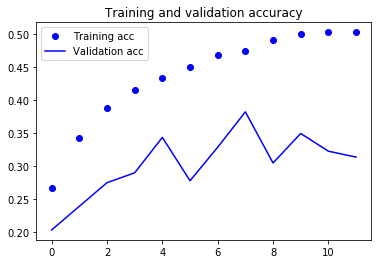

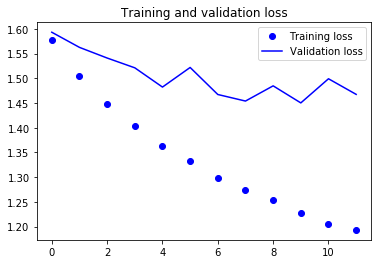

In [0]:
import matplotlib.pyplot as plt

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Classification Validation Results

In [0]:
# Inspiration on generating scores for classification training
# https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model_inception.predict_generator(validation_generator, 355/batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['resized_0','resized_1','resized_2','resized_3','resized_4']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[39  9  5 17  1]
 [23 10 16 19  3]
 [26  4  9 29  3]
 [ 5  5  7 38 16]
 [ 4  2  8 13 44]]
Classification Report
              precision    recall  f1-score   support

   resized_0       0.40      0.55      0.46        71
   resized_1       0.33      0.14      0.20        71
   resized_2       0.20      0.13      0.16        71
   resized_3       0.33      0.54      0.41        71
   resized_4       0.66      0.62      0.64        71

    accuracy                           0.39       355
   macro avg       0.38      0.39      0.37       355
weighted avg       0.38      0.39      0.37       355



In [0]:
confusion_matrix_object = confusion_matrix(validation_generator.classes, y_pred) 

In [0]:
# Accuracy overall
(confusion_matrix_object[0,0] + confusion_matrix_object[1,1]+ confusion_matrix_object[2,2]+ confusion_matrix_object[3,3]) / 355

0.2704225352112676

# Classification Testing Results

In [0]:
test_dir = os.path.join(directory, data_folder_name, 'test')

testing_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(x, y),
        batch_size=batch_size,
        shuffle = False,
        class_mode='categorical')
# 355/5=71

Found 355 images belonging to 5 classes.


In [0]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
Y_pred_test = model_inception.predict_generator(testing_generator, 355/batch_size)
y_pred_test = np.argmax(Y_pred_test, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testing_generator.classes, y_pred_test))
print('Classification Report')
target_names = ['resized_0','resized_1','resized_2','resized_3','resized_4']
print(classification_report(testing_generator.classes, y_pred_test, target_names=target_names))

confusion_matrix_object_test = confusion_matrix(testing_generator.classes, y_pred_test) 

# Overall accuracy
(confusion_matrix_object_test[0,0] + confusion_matrix_object_test[1,1]+ confusion_matrix_object_test[2,2]+ confusion_matrix_object_test[3,3]) / 355

Confusion Matrix
[[39  9  8  9  6]
 [40 11  4 14  2]
 [21  5 13 24  8]
 [10  5  5 36 15]
 [ 6  0 14 18 33]]
Classification Report
              precision    recall  f1-score   support

   resized_0       0.34      0.55      0.42        71
   resized_1       0.37      0.15      0.22        71
   resized_2       0.30      0.18      0.23        71
   resized_3       0.36      0.51      0.42        71
   resized_4       0.52      0.46      0.49        71

    accuracy                           0.37       355
   macro avg       0.37      0.37      0.35       355
weighted avg       0.37      0.37      0.35       355



0.27887323943661974